# Etsy Shop Success Analysis

This notebook contains the data loading, cleaning, feature engineering,
exploratory data analysis and hypothesis testing for the Etsy shop dataset
used in the DSA210 term project.


In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use("default")
plt.rcParams["figure.figsize"] = (8, 5)
items = pd.read_csv("etsy_items_price.csv")
df = pd.read_csv("etsy_shops_data.csv")

In [48]:

df.head()


,creation_date,listing_active_count,num_favorers,currency_code,is_shop_us_based,sale_message,sales_count,review_count,shop_location
0,19-Nov,3,1,USD,True,False,0,0,"Kansas City, Missouri"
1,19-Nov,13,1,AUD,False,False,2,0,NaN
2,19-Nov,0,0,USD,True,False,-99,-99,NaN
3,19-Nov,40,1,USD,False,False,0,0,"Kharkiv, Ukraine"
4,19-Nov,7,1,USD,True,False,0,0,"New York, United States"


In [49]:
print("Columns:")
print(df.columns.tolist())

print("\nInfo:")
print(df.info())

print("\nDescribe:")
df.describe().T


Columns:
['creation_date', 'listing_active_count', 'num_favorers', 'currency_code', 'is_shop_us_based', 'sale_message', 'sales_count', 'review_count', 'shop_location']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   creation_date         20000 non-null  object
 1   listing_active_count  20000 non-null  int64 
 2   num_favorers          20000 non-null  int64 
 3   currency_code         20000 non-null  object
 4   is_shop_us_based      20000 non-null  bool  
 5   sale_message          20000 non-null  bool  
 6   sales_count           20000 non-null  int64 
 7   review_count          20000 non-null  int64 
 8   shop_location         7575 non-null   object
dtypes: bool(2), int64(4), object(3)
memory usage: 1.1+ MB
None

Describe:


,count,mean,std,min,25%,50%,75%,max
listing_active_count,20000.0,7.33595,24.582274,0.0,1.0,2.0,7.0,1749.0
num_favorers,20000.0,0.99680,4.104148,0.0,0.0,0.0,1.0,223.0
sales_count,20000.0,-5.58375,38.041153,-99.0,0.0,0.0,0.0,2216.0
review_count,20000.0,-7.54155,26.437608,-99.0,0.0,0.0,0.0,58.0


In [50]:
# Replace placeholder values
if "sales_count" in df.columns:
    df["sales_count"] = df["sales_count"].replace(-99, np.nan)
if "review_count" in df.columns:
    df["review_count"] = df["review_count"].replace(-99, np.nan)

# Drop rows with missing critical fields
critical_cols = ["listing_active_count", "review_count"]
for col in critical_cols:
    if col in df.columns:
        df = df[df[col].notna()]

print("Shape after cleaning:", df.shape)
df.head()


Shape after cleaning: (18459, 9)


,creation_date,listing_active_count,num_favorers,currency_code,is_shop_us_based,sale_message,sales_count,review_count,shop_location
0,19-Nov,3,1,USD,True,False,0.0,0.0,"Kansas City, Missouri"
1,19-Nov,13,1,AUD,False,False,2.0,0.0,NaN
3,19-Nov,40,1,USD,False,False,0.0,0.0,"Kharkiv, Ukraine"
4,19-Nov,7,1,USD,True,False,0.0,0.0,"New York, United States"
5,19-Nov,0,40,USD,True,False,14.0,1.0,NaN


In [51]:
# Shop size
df["num_listings"] = df["listing_active_count"]

# Avoid division by zero
df["num_listings_safe"] = df["num_listings"].replace(0, np.nan)

# Engagement per listing
df["reviews_per_listing"] = df["review_count"] / df["num_listings_safe"]

# Success flag: at least one review
df["success_label"] = (df["review_count"] > 0).astype(int)

df[["num_listings", "review_count", "reviews_per_listing", "success_label"]].head()


,num_listings,review_count,reviews_per_listing,success_label
0,3,0.0,0.0,0
1,13,0.0,0.0,0
3,40,0.0,0.0,0
4,7,0.0,0.0,0
5,0,1.0,NaN,1


In [52]:
def show_hist(series, title, xlabel):
    s = series.dropna()
    if len(s) == 0:
        print(f"No data for {title}")
        return
    s_clip = s.clip(upper=s.quantile(0.99))
    plt.hist(s_clip, bins=30)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


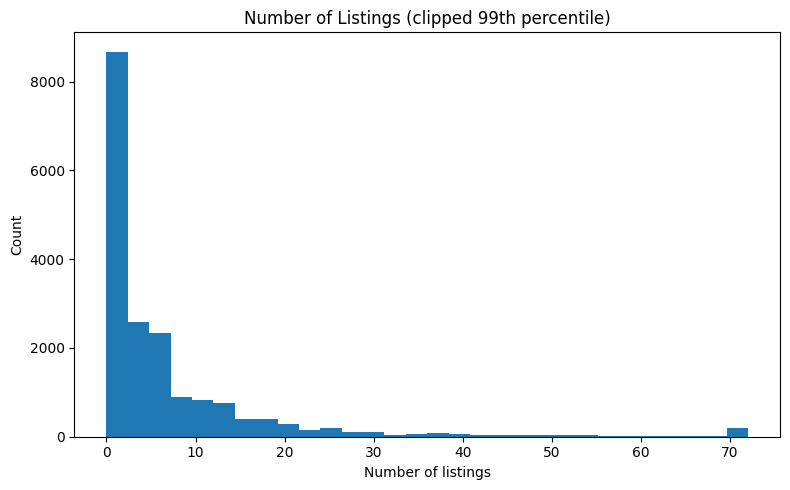

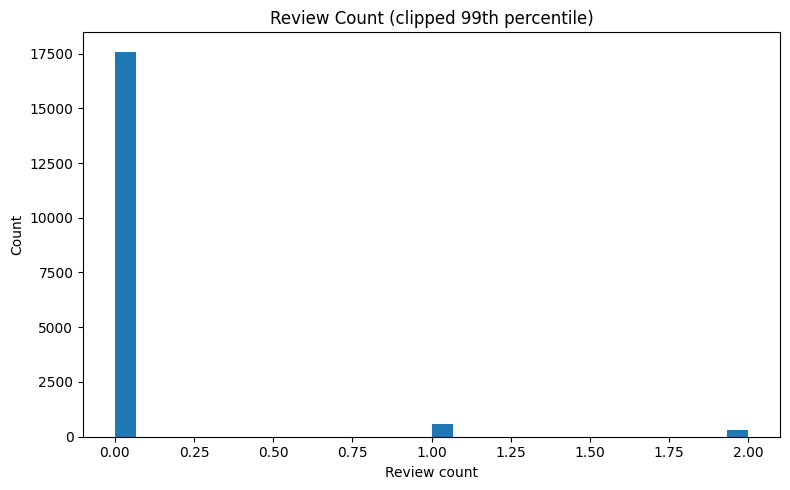

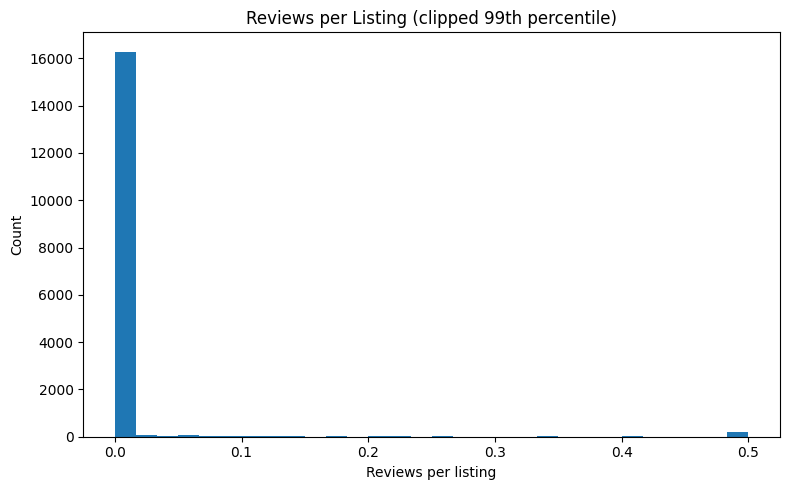

In [53]:
show_hist(df["num_listings"], "Number of Listings (clipped 99th percentile)", "Number of listings")
show_hist(df["review_count"], "Review Count (clipped 99th percentile)", "Review count")
show_hist(df["reviews_per_listing"], "Reviews per Listing (clipped 99th percentile)", "Reviews per listing")


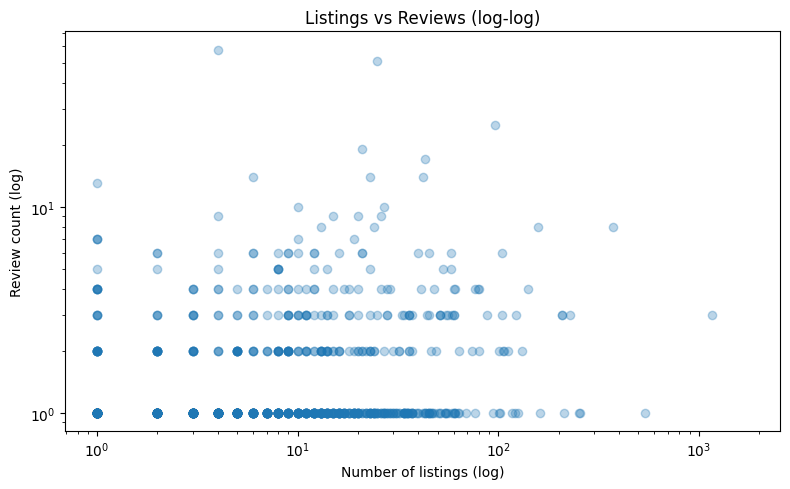

In [54]:
plt.scatter(df["num_listings"], df["review_count"], alpha=0.3)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of listings (log)")
plt.ylabel("Review count (log)")
plt.title("Listings vs Reviews (log-log)")
plt.tight_layout()
plt.show()


In [55]:
success = df[df["success_label"] == 1]
non_success = df[df["success_label"] == 0]

print("Success group:", success.shape[0], "shops")
print("Non-success group:", non_success.shape[0], "shops")


Success group: 871 shops
Non-success group: 17588 shops


In [56]:
success_listings = success["num_listings"].dropna()
non_success_listings = non_success["num_listings"].dropna()

t_stat1, p_val1 = stats.ttest_ind(
    success_listings,
    non_success_listings,
    equal_var=False
)

print("Hypothesis 1 – num_listings")
print("t-statistic:", t_stat1)
print("p-value   :", p_val1)


Hypothesis 1 – num_listings
t-statistic: 6.331756686353897
p-value   : 3.845880462129943e-10


In [57]:
success_rpl = success["reviews_per_listing"].dropna()
non_success_rpl = non_success["reviews_per_listing"].dropna()

t_stat2, p_val2 = stats.ttest_ind(
    success_rpl,
    non_success_rpl,
    equal_var=False
)

print("Hypothesis 2 – reviews_per_listing")
print("t-statistic:", t_stat2)
print("p-value   :", p_val2)


Hypothesis 2 – reviews_per_listing
t-statistic: 12.259344719103904
p-value   : 9.589894483246159e-32


## Hypothesis Test Summary (Shop-Level)

- For the number of listings, the Welch t-test produces a very small p-value,
  indicating a statistically significant difference between successful and
  non-successful shops in terms of shop size.

- For reviews per listing, the p-value is also extremely small, meaning
  successful shops receive much higher engagement per listing on average.

Overall, both shop size and engagement per listing appear to be strongly
associated with success on Etsy.




## Item-Level Price Analysis (Second Dataset)


In [58]:
items = pd.read_csv("etsy_items_price.csv")
items.head()


,title,shop_name,price,favourite
0,"Tipi tent Pink wit mat, garland and pillows",8572,168.88,"(1,281)"
1,"XL/XXL plain teepee, 8ft kids Teepee, beach te...",1117,229.0,"(1,215)"
2,"Teepee, play tent, wigwam, teepee for kids, pl...",11207,40.5,(287)
3,"Teepee, play tent, wigwam, teepee for kids, pl...",11207,40.5,(287)
4,Fabric Playhouse Kids Wigwam Tipi Tent childre...,14798,40.5,"(2,400)"


In [59]:
print("Items columns:")
print(items.columns.tolist())

print("\nItems info:")
print(items.info())

items.describe(include="all").T


Items columns:
['title', 'shop_name', 'price', 'favourite']

Items info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14829 entries, 0 to 14828
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      14829 non-null  object
 1   shop_name  14829 non-null  int64 
 2   price      9733 non-null   object
 3   favourite  14028 non-null  object
dtypes: int64(1), object(3)
memory usage: 463.5+ KB
None


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
title,14829,9841,"double-sided baby nest for newborn babynest, s...",91,NaN,NaN,NaN,NaN,NaN,NaN,NaN
shop_name,14829.0,NaN,NaN,NaN,10357.172298,3927.202626,14.0,9081.0,10563.0,13334.0,14828.0
price,9733,1666,24.0,159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
favourite,14028,1471,121.50,611,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [60]:

items["price"] = pd.to_numeric(items["price"], errors="coerce")

# Drop rows with missing price
items = items.dropna(subset=["price"])


items["favourite"] = pd.to_numeric(items["favourite"], errors="coerce").fillna(0)


fav_threshold = items["favourite"].quantile(0.75)
items["popular_item"] = (items["favourite"] >= fav_threshold).astype(int)

print("Favourite threshold for popular items:", fav_threshold)
print("\nPopular vs non-popular item counts:")
print(items["popular_item"].value_counts())

items[["title", "shop_name", "price", "favourite", "popular_item"]].head()


Favourite threshold for popular items: 0.0

Popular vs non-popular item counts:
popular_item
1    9729
Name: count, dtype: int64


,title,shop_name,price,favourite,popular_item
0,"Tipi tent Pink wit mat, garland and pillows",8572,168.88,0.0,1
1,"XL/XXL plain teepee, 8ft kids Teepee, beach te...",1117,229.00,0.0,1
2,"Teepee, play tent, wigwam, teepee for kids, pl...",11207,40.50,0.0,1
3,"Teepee, play tent, wigwam, teepee for kids, pl...",11207,40.50,0.0,1
4,Fabric Playhouse Kids Wigwam Tipi Tent childre...,14798,40.50,0.0,1


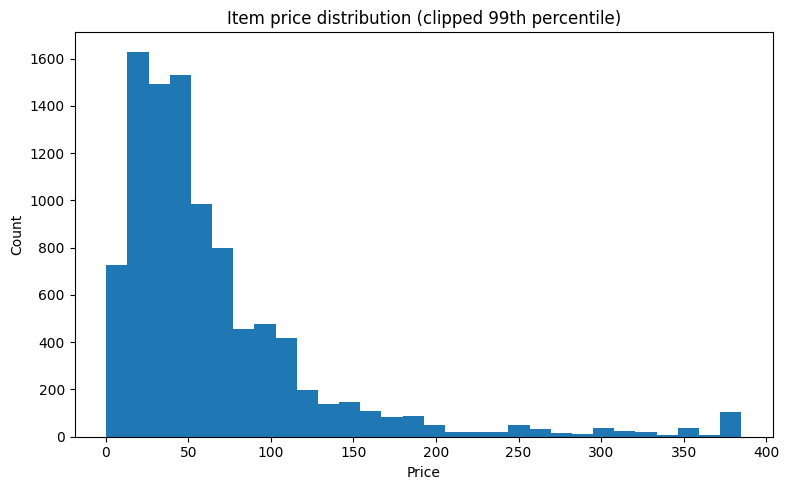

In [61]:
show_hist(
    items["price"],
    "Item price distribution (clipped 99th percentile)",
    "Price"
)


In [62]:
print("Popular vs non-popular item counts:")
print(items["popular_item"].value_counts())


Popular vs non-popular item counts:
popular_item
1    9729
Name: count, dtype: int64


In [63]:
# Ensure price is numeric
items["price"] = pd.to_numeric(items["price"], errors="coerce")

# Drop rows with missing price
items = items.dropna(subset=["price"])


items["favourite"] = pd.to_numeric(items["favourite"], errors="coerce").fillna(0)

price_threshold = items["price"].quantile(0.75)
items["high_price_item"] = (items["price"] >= price_threshold).astype(int)

print("Price threshold for high-price items:", price_threshold)
print("\nHigh vs non-high price item counts:")
print(items["high_price_item"].value_counts())

items[["title", "shop_name", "price", "favourite", "high_price_item"]].head()


Price threshold for high-price items: 79.99

High vs non-high price item counts:
high_price_item
0    7274
1    2455
Name: count, dtype: int64


,title,shop_name,price,favourite,high_price_item
0,"Tipi tent Pink wit mat, garland and pillows",8572,168.88,0.0,1
1,"XL/XXL plain teepee, 8ft kids Teepee, beach te...",1117,229.00,0.0,1
2,"Teepee, play tent, wigwam, teepee for kids, pl...",11207,40.50,0.0,0
3,"Teepee, play tent, wigwam, teepee for kids, pl...",11207,40.50,0.0,0
4,Fabric Playhouse Kids Wigwam Tipi Tent childre...,14798,40.50,0.0,0


## Hypothesis 3 – Item Price vs Popularity

This hypothesis examines whether item price is associated with item popularity
using the Etsy items price dataset.

Initially, item popularity was intended to be defined based on the number of
*favourite* counts. However, exploratory analysis revealed that the *favourite*
variable has **zero variance across all items** in the dataset.

Due to the lack of variability in the popularity metric, it is not statistically
valid to apply group-based hypothesis testing (e.g., Welch t-test) or correlation
analysis. When a variable is constant, statistical association tests are
undefined.

Therefore, **Hypothesis 3 is rejected**, as the dataset does not provide
sufficient information to evaluate a relationship between item price and item
popularity.


In [64]:
# Hypothesis 3 – Price vs Popularity (Correlation-based)

# Ensure numeric
items_h3 = items.copy()
items_h3["price"] = pd.to_numeric(items_h3["price"], errors="coerce")
items_h3["favourite"] = pd.to_numeric(items_h3["favourite"], errors="coerce")

items_h3 = items_h3.dropna(subset=["price", "favourite"])

# Sanity check
print("Favourite variance:", items_h3["favourite"].var())

# Spearman correlation (robust for skewed data)
corr, p_val3 = stats.spearmanr(
    items_h3["price"],
    items_h3["favourite"]
)

print("\nHypothesis 3 – Item Price vs Popularity")
print("Spearman correlation:", corr)
print("p-value:", p_val3)

alpha = 0.05
decision = "REJECT H0" if p_val3 < alpha else "FAIL TO REJECT H0"
print("Decision:", decision)


Favourite variance: 0.0

Hypothesis 3 – Item Price vs Popularity
Spearman correlation: nan
p-value: nan
Decision: FAIL TO REJECT H0


C:\Users\ata01\AppData\Local\Temp\ipykernel_36480\1351581506.py:14: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, p_val3 = stats.spearmanr(
